In [2]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.patches as patches
from torchvision.ops import roi_align
from tqdm import tqdm
from torch.autograd import Variable
from torchvision.transforms.functional import crop as tf_crop

from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
import einops

In [3]:
import kagglehub

# Download latest version
path = "/kaggle/input/ccpd-preprocess"

print("Path to dataset files:", os.listdir(path))

Path to dataset files: ['CCPD2019']


In [4]:
dataset_path=path+'/CCPD2019/' #To be changed to another path if NOT training


In [5]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters): #The function needed to return the character sequence from the indices
    return ''.join([all_characters[i] for i in indices if i < len(all_characters)])

Number of characters: 68


In [6]:
class CCPD_Dataset(Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path=os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size
        if self.transform:
            image = self.transform(Image.open(img_path).convert("RGB"))
        else:
            image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        # Target size after transform
        target_w, target_h = 300, 300

        # Scale bbox coordinates
        x1 = x1 * target_w / orig_w
        x2 = x2 * target_w / orig_w
        y1 = y1 * target_h / orig_h
        y2 = y2 * target_h / orig_h

        # Now turn the characters field into a tensor of indices (integers)
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx
        
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        charas = torch.tensor([charaslistdef], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "charas": charas
        }
        return image, target

In [7]:
# Check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Using device: cpu


In [8]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))
# The augmented version
E2E_transform = transforms.Compose([
    transforms.Resize((340, 340)),
    transforms.RandomRotation(degrees=random.randint(0, 15)),
    transforms.CenterCrop((300, 300)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# The base version
no_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# This selects one of the two transformations at random for each image.
class RandomTransformSelector:
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        transform = random.choice(self.transforms_list)
        return transform(img)

random_transform = RandomTransformSelector([E2E_transform, no_transform])
train_dataset = CCPD_Dataset(dataset_path, train_list, transform=random_transform)
val_dataset = CCPD_Dataset(dataset_path, val_list, transform=no_transform)
test_dataset = CCPD_Dataset(dataset_path, test_list, transform=no_transform)

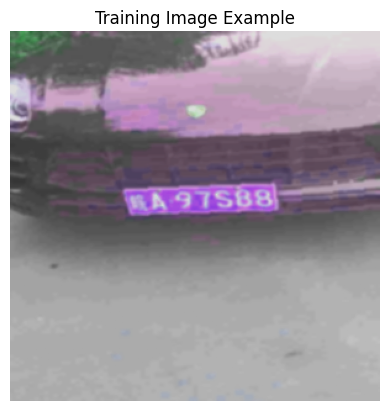

In [10]:
# Train dataset example
image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Training Image Example")
plt.show()

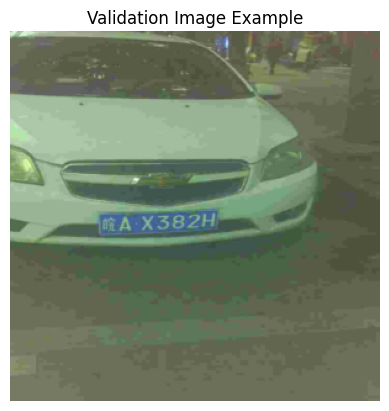

In [11]:
# Train dataset example
image, target = val_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Validation Image Example")
plt.show()

In [12]:
def collate_dicttargets(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

In [ ]:
# class FastRCNN(nn.Module):
#     def __init__(self, num_classes=2, num_anchors=9):
#         super(FastRCNN, self).__init__()
#         self.num_classes = num_classes
#         model_base = torchvision.models.resnet34(pretrained=True)
#         self.base = nn.Sequential(*(list(model_base.children())[:-2]))
#         self.shared_conv = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(256, 256)
#         self.dropout = nn.Dropout(0.5)
#         self.classifier = nn.Linear(256, num_classes)
#         self.bbox_pred = nn.Linear(256, num_classes * 4)

#     def forward(self, x, proposals):
#         if isinstance(x, list):
#             x = torch.stack(x)  # [B, C, H, W]

#         features = self.base(x)
#         features2 = self.shared_conv(features)
#         shared_features = self.relu(features2)

#         # ---- 🔧 Fix: Format proposals correctly ----
#         if isinstance(proposals, list):
#             # Convert list[Tensor[K, 4]] → Tensor[N, 5] where 1st col is batch_idx
#             proposals_formatted = []
#             for i, boxes in enumerate(proposals):
#                 if boxes.numel() == 0:
#                     continue
#                 batch_indices = torch.full((boxes.size(0), 1), i, dtype=boxes.dtype, device=boxes.device)
#                 boxes_with_idx = torch.cat([batch_indices, boxes], dim=1)  # [K, 5]
#                 proposals_formatted.append(boxes_with_idx)
#             if len(proposals_formatted) == 0:
#                 raise ValueError("No valid proposals provided to roi_align.")
#             proposals = torch.cat(proposals_formatted, dim=0)  # [N, 5]
#         else:
#             raise TypeError("Expected proposals to be a list of Tensors.")

#         # --------------------------------------------

#         features_pooled = roi_align(
#             shared_features, proposals,
#             output_size=(7, 7),
#             spatial_scale=1.0 / 32.0,
#             sampling_ratio=2,
#             aligned=True
#         )

#         x = self.avgpool(features_pooled)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         x = self.dropout(x)
#         x = self.relu(x)

#         class_logits = self.classifier(x)
#         bbox_pred = self.bbox_pred(x)

#         output = {
#             "class_logits": class_logits,
#             "bbox_pred": bbox_pred,
#             "boxes": proposals
#         }

#         if not self.training:
#             probs = torch.softmax(class_logits, dim=-1)
#             scores, labels = probs.max(dim=-1)
#             output["scores"] = scores
#             output["labels"] = labels

#         return output

IndentationError: expected an indented block after function definition on line 15 (2837150264.py, line 16)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline2 = FastRCNN(num_classes=2).to(device)

#print(baseline2)
#print(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 142MB/s]


In [ ]:
# def FastRCNN_losses(preds,targets):
#   CEL=nn.CrossEntropyLoss()
#   L1=nn.SmoothL1Loss()
#   labels=torch.cat([target['labels'] for target in targets])
#   bbox=torch.cat([target['boxes'] for target in targets])
#   class_logits=preds["class_logits"]
#   bbox_pred=preds["bbox_pred"]

#   class_loss=CEL(class_logits,labels)
#   N=bbox_pred.size(0)
#   num_classes=2
#   bbox_pred = bbox_pred.view(N, num_classes, 4)
#   bbox_pred = bbox_pred[torch.arange(N), labels]
#   L1 = nn.SmoothL1Loss()
#   bbox_loss = L1(bbox_pred, bbox)
#   return {
#         "Class_loss": class_loss,
#         "bbox_loss": bbox_loss
#     }


In [14]:
# The CNN feature extractor for the character recognition task
cnnbackbone = torchvision.models.mobilenet_v3_large(weights='DEFAULT', progress=True)
#print(cnnbackbone)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 115MB/s] 


In [18]:
batch_size = 10
num_epochs = 3
learning_rate = 0.01
optimizer = torch.optim.Adam(baseline2.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dicttargets, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dicttargets)

In [ ]:
# for epoch in range(num_epochs):
#     baseline2.train()
#     running_loss = 0.0

#     for batch_idx, (images, targets) in enumerate(train_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]  # Use GT boxes as proposals for now

#         optimizer.zero_grad()
#         images_tensor = torch.stack(images, dim=0)  # Shape: [B, C, H, W]
#         predictions = baseline2(images_tensor, proposals)
#         loss_dict = FastRCNN_losses(predictions, targets)
#         loss = sum(loss for loss in loss_dict.values())
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if batch_idx % 10 == 0:
#             print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

#     print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {running_loss/len(train_loader):.4f}")

KeyboardInterrupt: 

In [15]:
#torch.save(baseline2.state_dict(), "fast_rcnn_weights.pth")

In [ ]:
# def show_bounding_box(image, boxes, scores=None, top_k=None):
#     image = image.permute(1, 2, 0).cpu().numpy()
#     image = (image * 0.5 + 0.5).clip(0, 1)
#     plt.imshow(image)
    
#     cmap = plt.colormaps.get_cmap('plasma')
    
#     #Colormap for confidence scores
#     if scores is not None:
#         if top_k is not None:
#             indices = np.argsort(scores)[-top_k:]
#             boxes = boxes[indices]
#             scores = scores[indices]
#         norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)  # Normalize to [0,1]
#         colors = cmap(norm_scores)
        
#     for i, box in enumerate(boxes):
#         x1, y1, x2, y2 = box
#         color = colors[i][:3] if scores is not None else 'red'
#         plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2))

#     if scores is not None and len(scores) > 0:
#         norm = mpl.colors.Normalize(vmin=scores.min(), vmax=scores.max())
#         sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
#         sm.set_array([])
#         cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
#         cbar.set_label('Confidence Score') 
           
#     plt.suptitle(f'Predicted Bounding Boxes (Showing best {len(boxes)} boxes)')   
#     plt.axis('off')
#     plt.show()

In [ ]:
# baseline2.load_state_dict(torch.load(
#     "/kaggle/input/fast_rcnn_weights/pytorch/default/1/fast_rcnn_weights.pth",
#     map_location=torch.device('cpu')
# ))
# baseline2.eval()
# val_loss = 0.0

# with torch.no_grad():
#     for batch_idx, (images, targets) in enumerate(val_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]  # Using ground-truth boxes as proposals

#         images_tensor = torch.stack(images, dim=0)  # Shape: [B, C, H, W]
#         predictions = baseline2(images_tensor, proposals)
#         loss_dict = FastRCNN_losses(predictions, targets)
#         loss = sum(loss for loss in loss_dict.values())
#         val_loss += loss.item()

#         if batch_idx % 10 == 0:
#             print(f"[Val] Batch {batch_idx}/{len(val_loader)}, Loss: {loss.item():.4f}")

# avg_val_loss = val_loss / len(val_loader)
# print(f"✅ Average Validation Loss: {avg_val_loss:.4f}")


[Val] Batch 0/10000, Loss: 5.7675
[Val] Batch 10/10000, Loss: 5.8441


KeyboardInterrupt: 

Predicted classes: [1]
Predicted bounding boxes: [[-2.1669436e+00 -3.9707959e-01 -4.2850983e-01 -4.5513637e-02]
 [ 1.3759804e+02  1.1954465e+02  2.4256802e+02  1.4471884e+02]]


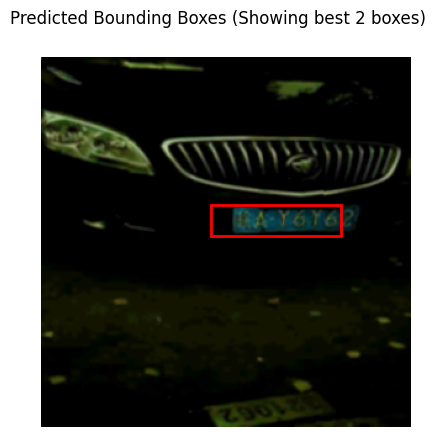

In [22]:
baseline2.eval()
with torch.no_grad():
    image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
    image = image.unsqueeze(0).to(device)
    proposals = target["boxes"].to(device).unsqueeze(0)  # Use GT box as proposal for this test

    # Run the model
    outputs = baseline2(image[0].unsqueeze(0), [proposals[0]])


    # Get predicted class and bbox
    class_logits = outputs["class_logits"]
    bbox_pred = outputs["bbox_pred"]

    # Get predicted class (excluding background if present)
    pred_class = class_logits.argmax(dim=1).cpu().numpy()
    pred_boxes = bbox_pred.cpu().numpy().reshape(-1, 4)

    print("Predicted classes:", pred_class)
    print("Predicted bounding boxes:", pred_boxes)

    # Optionally, show the first predicted box on the image
    show_bounding_box(image[0], pred_boxes, scores=None, top_k=None)

In [23]:
class PlateRecognizer(nn.Module):
    def __init__(self, num_classes=68, n_trainable=3):
        super().__init__()
        
        # Freeze all but the last n_trainable layers in the feature extractor
        features = list(cnnbackbone.features.children())
        for layer in features[:-n_trainable]:
            for param in layer.parameters():
                param.requires_grad = False
        cnnbackbone.features = nn.Sequential(*features)
                
        self.cnn = nn.Sequential(
            cnnbackbone.features,
            nn.AdaptiveAvgPool2d((1, None)) # The height needs to be 1 for the CTC to work properly  
        )
        self.rnn = nn.LSTM(960, 256, batch_first=True, bidirectional=True, device=device)
        self.fc = nn.Sequential(
            nn.Linear(512, num_classes*2),
            nn.ReLU(),
            nn.Linear(num_classes*2, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 3, 1)
        x = einops.rearrange(x, 'b h w c -> b (h w) c')
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

In [66]:
class PlateDetectAndRecon(nn.Module):
    def __init__(self, detector, recognizer, crop_size=(224, 224)):
        super().__init__()
        self.detector = detector
        self.recognizer = recognizer
        self.crop_size = crop_size
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def forward(self, images, targets=None):
        # Detection: forward pass
        if self.training:
            proposals = [t['boxes'] for t in targets]
        else:
            proposals = None  # Let detector propose regions automatically

        detector_outputs_raw = self.detector(images, proposals)
        detector_outputs = ([detector_outputs_raw] if isinstance(detector_outputs_raw, dict) else detector_outputs_raw)

        # Compute detection loss if training
        if self.training and targets is not None:
            loss_dict = FastRCNN_losses(detector_outputs, targets)
        else:
            loss_dict = {}

        batch_logits = []
        batch_boxes = []
        batch_scores = []

        for i, output in enumerate(detector_outputs):
            boxes = output['boxes']
            if isinstance(boxes, list):
                boxes = torch.stack(boxes).to(images[i].device)

            scores = output.get('scores', torch.ones(len(boxes), device=boxes.device))
            top_k = 5

            # Skip if no detections
            if len(boxes) == 0:
                continue

            # Select top-K boxes by score
            indices = scores.argsort(descending=True)[:top_k]
            boxes = boxes[indices]
            scores = scores[indices]

            # Pad if fewer than top_k
            if len(boxes) < top_k:
                pad_boxes = torch.zeros((top_k - len(boxes), 4), dtype=boxes.dtype, device=boxes.device)
                pad_scores = torch.zeros(top_k - len(scores), dtype=scores.dtype, device=scores.device)
                boxes = torch.cat([boxes, pad_boxes], dim=0)
                scores = torch.cat([scores, pad_scores], dim=0)

            # Crop and normalize
            crops = []
            image = images[i]
            _, H, W = image.shape
            for box in boxes:
                x1, y1, x2, y2 = box.int().tolist()
                x1 = max(0, min(x1, W - 1))
                x2 = max(0, min(x2, W))
                y1 = max(0, min(y1, H - 1))
                y2 = max(0, min(y2, H))

                if x2 <= x1 or y2 <= y1:
                    crop_img = image
                else:
                    crop_img = TF.crop(image, y1, x1, y2 - y1, x2 - x1)

                crop_img = TF.resize(crop_img, self.crop_size)
                crop_img = self.normalize(crop_img)
                crops.append(crop_img)

            crops = torch.stack(crops).to(image.device)
            logits = self.recognizer(crops)

            batch_logits.append(logits)
            batch_boxes.append(boxes)
            batch_scores.append(scores)

        if len(batch_logits) == 0:
            return None, None, None, loss_dict

        batch_logits = torch.stack(batch_logits)  # [B, top_k, T, C]
        return batch_logits, batch_boxes, batch_scores, loss_dict

In [67]:
lr_final = 0.01

detector = FastRCNN(num_classes=2)
recognizer = PlateRecognizer(num_classes=68)

# === Wrap in full model BEFORE loading detector weights ===
model = PlateDetectAndRecon(detector, recognizer)

# === Load weights correctly ===
if os.path.exists("fullmodel_checkpoint.pth"):
    checkpoint = torch.load("fullmodel_checkpoint.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("✅ Loaded full model with optimizer state.")

elif os.path.exists("/kaggle/input/fast_rcnn_weights/pytorch/default/1/fast_rcnn_weights.pth"):
    detector_weights = torch.load("/kaggle/input/fast_rcnn_weights/pytorch/default/1/fast_rcnn_weights.pth", map_location=device)
    model.detector.load_state_dict(detector_weights)
    print("✅ Loaded detector weights only (FastRCNN). Recognition head is randomly initialized.")

else:
    print("⚠️ No model weights found. Starting from scratch.")

# === Move everything to device ===
model = model.to(device)
recognizer = model.recognizer  # make sure recognizer ref is updated if needed

# Optimizer: jointly train both detector and recognizer
optimizer = torch.optim.Adam(
    list(model.detector.parameters()) + list(model.recognizer.parameters()), 
    lr=lr_final
)

# Loss for recognition (CTC)
ctc_loss_fn = nn.CTCLoss(blank=67, zero_infinity=True)

✅ Loaded detector weights only (FastRCNN). Recognition head is randomly initialized.


In [68]:
def decode_ctc_output(logits, all_characters):
    # logits shape: [T, C]
    # Take argmax at each timestep
    pred_indices = torch.argmax(logits, dim=-1).cpu().numpy()
    
    # Remove consecutive duplicates and blanks (blank index = 67)
    blank_idx = 67
    prev = None
    decoded = []
    for idx in pred_indices:
        if idx != prev and idx != blank_idx:
            decoded.append(idx)
        prev = idx
    return ''.join([all_characters[i] for i in decoded])

def plot_boxes_and_labels(image, boxes, labels):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5)  # denormalize
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box.int()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, label, fontsize=12, color='blue',
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# model.eval()
# num_correct = 0
# num_total = 0
# iou_threshold = 0.5

# def iou(boxA, boxB):
#     # box format: [x1, y1, x2, y2]
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[2], boxB[2])
#     yB = min(boxA[3], boxB[3])

#     interArea = max(0, xB - xA) * max(0, yB - yA)
#     boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
#     boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

#     iou = interArea / float(boxAArea + boxBArea - interArea)
#     return iou

# with torch.no_grad():
#     for batch_idx, (images, targets) in enumerate(val_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]
#         logits, pred_boxes_list, scores_list, loss_dict = model(images, targets=targets, proposals=proposals)

#         # logits: [B, top_k, T, C]

#         for i, image in enumerate(images):
#             pred_boxes = pred_boxes_list[i]
#             scores = scores_list[i]
#             logits_i = logits[i]  # [top_k, T, C]

#             # Use highest score box only or loop all top_k
#             for box_idx in range(len(pred_boxes)):
#                 if scores[box_idx] < 0.3:  # confidence threshold
#                     continue

#                 logit = logits_i[box_idx]  # [T, C]
#                 pred_plate = decode_ctc_output(logit, all_characters)

#                 # Ground truth info for comparison (optional)
#                 gt_box = targets[i]['boxes'][0]
#                 gt_chars = targets[i]['charas'][0]
#                 print(gt_chars.shape)
#                 gt_plate = decode_sequence(gt_chars.cpu().numpy(), all_characters)

#                 # Compute IoU between pred box and gt box for detection metric
#                 iou_score = iou(pred_boxes[box_idx].cpu().numpy(), gt_box.cpu().numpy())

#                 print(f"Predicted Plate: {pred_plate}, Score: {scores[box_idx]:.2f}, IoU: {iou_score:.2f}")
#                 print(f"Ground Truth Plate: {gt_plate}")

#                 # Count correct recognitions with IoU > threshold and exact plate match
#                 if iou_score > iou_threshold and pred_plate == gt_plate:
#                     num_correct += 1
#                 num_total += 1

#             # Visualize boxes and plates on the image
#             labels = []
#             for box_idx in range(len(pred_boxes)):
#                 if scores[box_idx] >= 0.3:
#                     plate_str = decode_ctc_output(logits_i[box_idx], all_characters)
#                     labels.append(plate_str)
#                 else:
#                     labels.append('')

#             plot_boxes_and_labels(image.cpu(), pred_boxes.cpu(), labels)

# print(f"Recognition accuracy (IoU>{iou_threshold} & exact match): {num_correct}/{num_total} = {num_correct/num_total:.4f}")


TypeError: PlateDetectAndRecon.forward() got an unexpected keyword argument 'proposals'